# Data Analysis
for model selection and results analysis 

## Libraries and imports

In [8]:
import sys
sys.path.append('..')
from scripts.utils import initialize_bucket, plot_importance

from datetime import date

import pandas as pd
import numpy as np
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import KFold, cross_val_score,cross_validate
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, explained_variance_score,mean_absolute_percentage_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.decomposition import PCA


from sklearn.preprocessing import StandardScaler, Normalizer

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import shap

import pickle
import json

In [9]:
pd.set_option("display.max_columns", 400)

credentials_path = '../datascience-capstone-project-05b1642f45c3.json'

In [10]:
client, bucket = initialize_bucket(credentials_path,'storage-barsianize')

path = "gs://storage-barsianize/05_datasets/df_base_dataset.parquet"
df =  pd.read_parquet(path)

path = "gs://storage-barsianize/05_datasets/df_to_pred.parquet"
df_to_pred =  pd.read_parquet(path)

In [11]:
df.dtypes

Empresa                object
Papel                  object
year_month             object
dy_label               object
year_last              object
                        ...  
roe_mean_ref_mean      object
pebit_mean_ref_mean    object
pa_mean_trend          object
ibovespa_trend         object
igpm_trend             object
Length: 111, dtype: object

## Methods and functions

In [12]:
def to_numeric(data):
    cols = data.columns
    for col in cols:
        try:
            data[col] = pd.to_numeric(data[col])
        except:
            continue
    return data

In [13]:
def load_model(path, model_name):
    """Load a trained model and associated preprocessing transformer.

    This function loads a trained machine learning model and identifies the appropriate
    estimator (LightGBM Regressor or XGBoost Regressor) from the pipeline steps. It also
    identifies any preprocessing transformers used in the pipeline.

    Args:
        path (str): The path to the directory containing the model file.
        model_name (str): The name of the model file.

    Returns:
        tuple: A tuple containing the loaded estimator and the preprocessing transformer.

    Raises:
        FileNotFoundError: If the specified model file does not exist.
    """
    with open(path + model_name, 'rb') as file:
        model = pickle.load(file)

    loaded_model = None
    for step_name, step_model in model.named_steps.items():
        if isinstance(step_model, LGBMRegressor):
            loaded_model = step_model
            break
        elif isinstance(step_model, XGBRegressor):
            loaded_model = step_model
            break
        elif step_name == 'preprocessing':
            transformer = step_model

    return loaded_model, transformer

In [14]:
def make_predictions(path, model_name, results_file, X_to_pred):
    """Make predictions using a trained model and return necessary components.

    This function loads a trained pipeline model and other relevant components,
    and then uses the model to predict target values for the provided data.

    Args:
        path (str): The path to the directory where the model and results file are located.
        model_name (str): The filename of the trained model in pickle format.
        results_file (str): The filename of the JSON results file containing features information.
        X_to_pred (pandas.DataFrame): The input data for which predictions need to be made.

    Returns:
        tuple: A tuple containing the following items:
            - predictions (numpy.ndarray): Predicted target values for the input data.
            - pipeline (sklearn.pipeline.Pipeline): The loaded pipeline model.
            - model: The trained machine learning model.
            - transformer: The data transformer used in the pipeline.
            - features (list): List of selected feature names used for predictions.

    Raises:
        FileNotFoundError: If the specified model file or results file does not exist.

    Example:
        # Assuming the trained model is saved as 'model.pkl' and results are in 'results.json'
        predictions, pipeline, model, transformer, features = make_predictions(
            'path/to/files/',
            'model.pkl',
            'results.json',
            X_test
        )
    """
    # model_name = '2023-08-04_LGBMRegressor_Normalizer()_feat_selection.pkl'
    with open(path + model_name, 'rb') as file:
        pipeline = pickle.load(file)

    with open(path + results_file, 'rb') as json_file:
        results = json.load(json_file)

    model, transformer = load_model(path, model_name)

    features = results['features']

    return pipeline.predict(X_to_pred[features]), pipeline, model, transformer, features

In [15]:
def get_feature_importances(model, model_class, features):
    """Get feature importances from a trained boosting model.

    This function calculates feature importances from a trained boosting model
    (LightGBM or XGBoost) based on their contribution to the model's predictions.

    Args:
        model (object): A trained boosting model object.
        model_class (str): A string indicating the class of the model (e.g., 'LGBM', 'XGB').
        features (list): A list of feature names used during training.

    Returns:
        pandas.DataFrame: A DataFrame containing feature importances sorted by total gain.

    Example:
        >>> import lightgbm as lgb
        >>> from xgboost import XGBRegressor
        >>> from sklearn.datasets import load_boston
        >>> boston = load_boston()
        >>> X, y, feature_names = boston.data, boston.target, boston.feature_names
        >>> lgb_model = lgb.LGBMRegressor().fit(X, y)
        >>> xgb_model = XGBRegressor().fit(X, y)
        >>> feature_importances_lgb = get_feature_importances(lgb_model, 'LGBM', feature_names)
        >>> feature_importances_xgb = get_feature_importances(xgb_model, 'XGB', feature_names)
    """    
    if 'LGB' in model_class:
        feature_importances = model.booster_.feature_importance(importance_type='gain')
    elif 'XGB' in model_class:
        feature_importances = model.get_booster().get_score(importance_type='gain').values()
        
    # Create a dictionary to associate feature names with their importance scores
    feature_importance_dict = dict(zip(features, feature_importances))
    df_feature_importance = pd.DataFrame(feature_importance_dict, 
                                      index=['Total gain']).T.sort_values(by='Total gain', ascending=False)
    return df_feature_importance

In [16]:
def calculate_shap_values(model, transformer, X_train, X_test, path, filename, plot=False):
    """
    Calculate SHAP (SHapley Additive exPlanations) values for a model's predictions.

    Args:
        model: A trained machine learning model.
        transformer: A data transformer or preprocessor used in the pipeline.
        X_train: The training data used for transformer fitting.
        X_test: The test data for which SHAP values will be calculated.
        path (str): The path to the directory where SHAP values will be saved.
        filename (str): The filename for saving the SHAP values.
        plot (bool, optional): If True, a summary plot of SHAP values will be generated.

    Returns:
        shap_values: The calculated SHAP values for the test data.
    """    
    # If the LightGBM model is found, convert it to a LightGBM Booster object and prepare the explainer
    if model is not None:
        # Assuming you have your test data in 'X_test' (replace 'X_test' with your actual test data)
        explainer = shap.Explainer(model, transformer.transform(X_train))

        # Calculate SHAP values for the test data
        shap_values = explainer(transformer.transform(X_test), check_additivity=False)

        # Save SHAP values to a file using pickle
        with open(path + filename, 'wb') as file:
            pickle.dump(shap_values, file)

        # plot shap summary if desired
        if plot:
            shap.summary_plot(shap_values, X_test)
        
        # Return SHAP values
        return shap_values
    
    else:
        print("LightGBM model not found in the pipeline.")
    

In [17]:
def get_dy_metrics(data, sort_col, filter_col,value_filter):
    """
    Calculate metrics related to 'dy_label', 'pl_mean_last', and 'cotacao_mean_last' based on different filters.

    Parameters:
    data (pd.DataFrame): Input DataFrame containing the data.
    sort_col (str): The column name to sort the data by.
    filter_col (str): The column name to filter the data by.
    value_filter: The value to filter the data on 'filter_col'.

    Returns:
    pd.DataFrame: A DataFrame containing calculated metrics based on different filters.
    """
    data = data.sort_values(by=sort_col, ascending=False)
    
    d = {}
    d['top5'] = {
                        'dy_mean'     : data['dy_label'].iloc[:5].mean(),
                        'pl_mean_last'     : data['pl_mean_last'].iloc[:5].mean(),
                        'cotacao_mean_last': data['cotacao_mean_last'].iloc[:5].mean()
                    }

    d['top10'] = {
                        'dy_mean'     : data['dy_label'].iloc[:10].mean(),
                        'pl_mean_last'     : data['pl_mean_last'].iloc[:10].mean(),
                        'cotacao_mean_last': data['cotacao_mean_last'].iloc[:10].mean()
                    }

    d['top20'] = {
                        'dy_mean'     : data['dy_label'].iloc[:20].mean(),
                        'pl_mean_last'     : data['pl_mean_last'].iloc[:20].mean(),
                        'cotacao_mean_last': data['cotacao_mean_last'].iloc[:20].mean()
                    }

    d[f'top5_{filter_col}'] = {
                        'dy_mean'     : data[data[filter_col]>=value_filter]['dy_label'].iloc[:5].mean(),
                        'pl_mean_last'     : data[data[filter_col]>=value_filter]['pl_mean_last'].iloc[:5].mean(),
                        'cotacao_mean_last': data[data[filter_col]>=value_filter]['cotacao_mean_last'].iloc[:5].mean()
                    }

    d[f'top10_{filter_col}'] = {
                        'dy_mean'     : data[data[filter_col]>=value_filter]['dy_label'].iloc[:10].mean(),
                        'pl_mean_last'     : data[data[filter_col]>=value_filter]['pl_mean_last'].iloc[:10].mean(),
                        'cotacao_mean_last': data[data[filter_col]>=value_filter]['cotacao_mean_last'].iloc[:10].mean()
                    }

    d[f'top20_{filter_col}'] = {
                        'dy_mean'     : data[data[filter_col]>=value_filter]['dy_label'].iloc[:20].mean(),
                        'pl_mean_last'     : data[data[filter_col]>=value_filter]['pl_mean_last'].iloc[:20].mean(),
                        'cotacao_mean_last': data[data[filter_col]>=value_filter]['cotacao_mean_last'].iloc[:20].mean()
                    }

    return pd.DataFrame(d)

In [18]:
def plot_results(data, y, title, palette):
    """
    Plot the results using a bar plot.

    Parameters:
        data (pandas.DataFrame): The data containing results to be plotted.
        y (str): The name of the column containing the y-axis data.
        title (str): The title of the plot.
        palette (str or list of str): The color palette for the bars.

    Returns:
        None
    """    
    plt.figure(figsize=(20,20), dpi=400)
    ax = sns.barplot(x=data.sort_values(y).index,
                    y=y, palette=palette, data=data.sort_values(y))
    # ax = sns.barplot(x=df_grupos_de_despesas.index[:-1],
    #                  y='Valor', palette='viridis', data=df_grupos_de_despesas[:-1])
    plt.xlabel('Model Output',fontsize=24)
    plt.ylabel('DY [-]', fontsize=20)
    plt.title(title, fontsize=24)
    plt.xticks(rotation=90, fontsize=20)
    plt.yticks(fontsize=20)

    for p in ax.patches:
        ax.annotate('{:,.3f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.005), fontsize=20,rotation=0)
    sns.despine()
    plt.tight_layout()


def create_syled_sheet(data, filter_word_in, sort_col, cmap):
    return data.sort_values(sort_col, ascending=False)[[col for col in data.columns if filter_word_in in col]]\
        .style.background_gradient(cmap=cmap,axis=0)


In [19]:
def analyse_resutls(df, data_resutls, path, model_name, results_file, file_name_SHAP, feature_name, X_to_pred):

    feature_name = model_name[11:].split('.')[0]

    data_resutls[feature_name], pipeline, model, transformer, features = make_predictions(path, model_name, results_file, X_to_pred)

    X = df[features]
    y = df['dy_label']
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

    shap = calculate_shap_values(model, transformer, X_train, X_test, path, file_name_SHAP, plot=True)

    return df, data_resutls, pipeline, model, transformer, features, shap


In [20]:
def get_analysis_inputs(date,sufix,algorithm,transformer):
    
    if sufix != '':
        sufix = '_'+sufix

    model_name     = f'{date}_{algorithm}_{transformer}{sufix}.pkl'
    results_file   = f'{date}_{algorithm}_{transformer}_results{sufix}.json'
    file_name_SHAP = f'{date}_{algorithm}_{transformer}_results{sufix}_SHAP.pkl'
    feature_name = model_name[11:].split('.')[0]

    return feature_name, model_name, results_file, file_name_SHAP

### Data Preprep

In [21]:
df         = to_numeric(df)
df_to_pred = to_numeric(df_to_pred)

## Analyse the prediction outcomes for each model
### Best models (Transformer + Algorithm + Feature Selection)

In [22]:
# separating the train and target features
X_to_pred = df_to_pred.drop(['year_month','Papel','Empresa','dy_label'], axis=1)
y_to_pred = df_to_pred['dy_label']

In [23]:
np.isin(['pl_mean_trend', 'pa_mean_trend', 'power_stabil'],df_to_pred.columns)

array([ True,  True,  True])

In [24]:
X_to_pred.columns

Index(['year_last', 'ibovespa_mean', 'ibovespa_last', 'igpm_mean', 'igpm_last',
       'Tipo_1', 'ibovespa_spread_relevance', 'ibovespa_spread',
       'pib_dolarizado_mean', 'pib_dolarizado_last',
       ...
       'pcg_mean_last', 'pvp_mean_trend', 'selic_trend', 'pvp_mean_ref_mean',
       'power_margin', 'roe_mean_ref_mean', 'pebit_mean_ref_mean',
       'pa_mean_trend', 'ibovespa_trend', 'igpm_trend'],
      dtype='object', length=107)

In [25]:
# path = '../data/03_models/out/'

# # '2023-08-28_LGBMRegressor_Normalizer()_feat_selection.pkl'

# model_name = '2023-08-28_LGBMRegressor_Normalizer()_feat_selection.pkl'
# results_file = '2023-08-28_LGBMRegressor_Normalizer()_results_feat_selection.json'
# file_name_SHAP = '2023-08-28_LGBMRegressor_Normalizer()_results_feat_selection_SHAP.pkl'

# df_to_pred['dy_pred_N_FS'], N_FS_0807_pipeline, N_FS_0807_model, N_FS_0807_transformer, N_FS_0807_features = make_predictions(path, model_name, results_file, X_to_pred)

# X = df[N_FS_0807_features]
# y = df['dy_label']
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

# N_FS_0807_shap = calculate_shap_values(N_FS_0807_model, N_FS_0807_transformer, X_train, X_test, path, file_name_SHAP, plot=True)



# # '2023-08-28_LGBMRegressor_StandardScaler()_feat_selection.pkl' 

# model_name = '2023-08-28_LGBMRegressor_StandardScaler()_feat_selection.pkl'
# results_file = '2023-08-28_LGBMRegressor_StandardScaler()_results_feat_selection.json'
# file_name_SHAP = '2023-08-28_LGBMRegressor_StandardScaler()_results_feat_selection_SHAP.pkl'

# df_to_pred['dy_pred_S_FS'], S_FS_0807_pipeline, S_FS_0807_model, S_FS_0807_transformer, S_FS_0807_features = make_predictions(path, model_name, results_file, X_to_pred)

# X = df[S_FS_0807_features]
# y = df['dy_label']
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

# S_FS_0807_shap = calculate_shap_values(S_FS_0807_model, N_FS_0807_transformer, X_train, X_test, path, file_name_SHAP, plot=True)



# path = '../data/03_models/out/'

# # '2023-08-05_LGBMRegressor_Normalizer()_feat_selection_lgbm.pkl'

# model_name = '2023-08-28_LGBMRegressor_Normalizer()_feat_selection_lgbm.pkl'
# results_file = '2023-08-28_LGBMRegressor_Normalizer()_results_feat_selection_lgbm.json'
# file_name_SHAP = '2023-08-28_LGBMRegressor_Normalizer()_results_feat_selection_lgbm_SHAP.pkl'

# df_to_pred['dy_pred_N_FS_LGBM'], N_FS_LGBM_0807_pipeline, N_FS_LGBM_0807_model, N_FS_LGBM_0807_transformer, N_FS_LGBM_0807_features = make_predictions(path, model_name, results_file, X_to_pred)

# X = df[N_FS_LGBM_0807_features]
# y = df['dy_label']
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

# N_FS_LGBM_0807_shap = calculate_shap_values(N_FS_LGBM_0807_model, N_FS_LGBM_0807_transformer, X_train, X_test, path, file_name_SHAP, plot=True)



# # '2023-08-28_LGBMRegressor_StandardScaler()_feat_selection_lgbm.pkl' 

# model_name = '2023-08-28_LGBMRegressor_StandardScaler()_feat_selection_lgbm.pkl'
# results_file = '2023-08-28_LGBMRegressor_StandardScaler()_results_feat_selection_lgbm.json'
# file_name_SHAP = '2023-08-28_LGBMRegressor_StandardScaler()_results_feat_selection_lgbm_SHAP.pkl'

# df_to_pred['dy_pred_S_FS_LGBM'], S_FS_LGBM_0807_pipeline, S_FS_LGBM_0807_model, S_FS_LGBM_0807_transformer, S_FS_LGBM_0807_features = make_predictions(path, model_name, results_file, X_to_pred)

# X = df[S_FS_LGBM_0807_features]
# y = df['dy_label']
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

# S_FS_LGBM_0807_shap = calculate_shap_values(S_FS_LGBM_0807_model, S_FS_LGBM_0807_transformer, X_train, X_test, path, file_name_SHAP, plot=True)

In [26]:
pipelines    = {}
models       = {}
transformers = {}
features     = {}
shaps        = {}

path = '../data/03_models/out/'

100%|===================| 22805/22833 [06:35<00:00]        

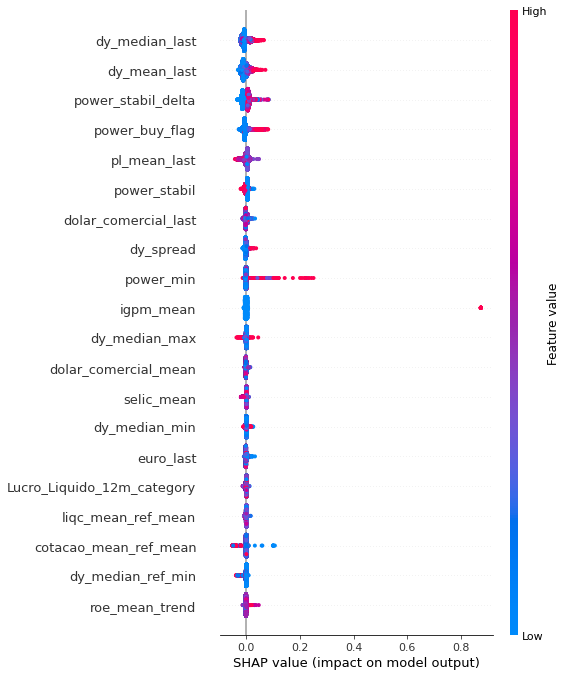

100%|===================| 22826/22833 [10:26<00:00]        

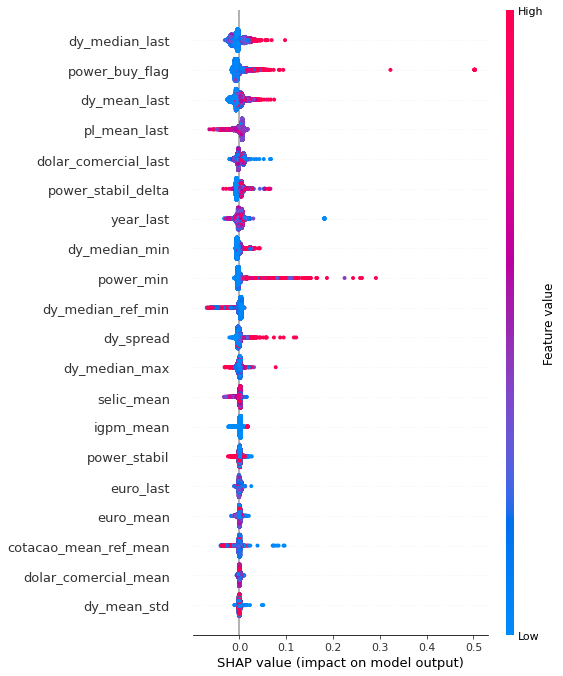

In [27]:
date = '2023-09-01'
sufix = ''
algorithm = 'LGBMRegressor'
transformer = 'Normalizer()'


feature_name, model_name, results_file, file_name_SHAP = get_analysis_inputs(date,sufix,algorithm,transformer)

df, df_to_pred, \
pipelines[feature_name], \
models[feature_name], \
transformers[feature_name], \
features[feature_name], \
shaps[feature_name] = analyse_resutls(df, df_to_pred, path, model_name, 
                                        results_file, 
                                        file_name_SHAP, 
                                        feature_name,
                                        X_to_pred)

date = '2023-09-01'
sufix = ''
algorithm = 'XGBRegressor'
transformer = 'Normalizer()'

feature_name = model_name[11:].split('.')[0]

feature_name, model_name, results_file, file_name_SHAP = get_analysis_inputs(date,sufix,algorithm,transformer)

df, df_to_pred, \
pipelines[feature_name], \
models[feature_name], \
transformers[feature_name], \
features[feature_name], \
shaps[feature_name] = analyse_resutls(df, df_to_pred, path, model_name, 
                                        results_file, 
                                        file_name_SHAP, 
                                        feature_name,
                                        X_to_pred)






100%|===================| 22831/22833 [15:15<00:00]        

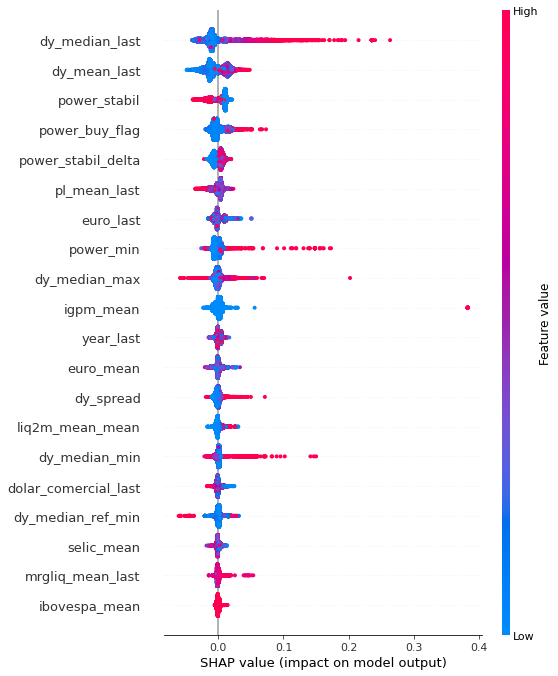

100%|===================| 22831/22833 [14:36<00:00]        

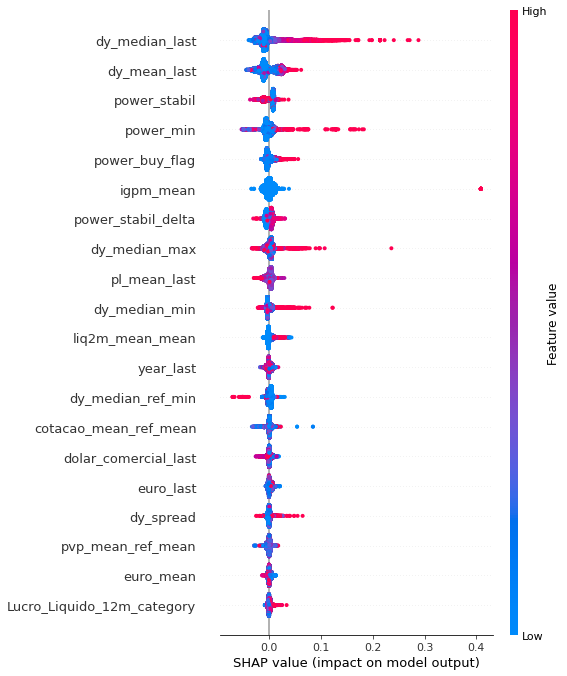

In [29]:
date = '2023-09-01'
sufix = 'feat_selection'
algorithm = 'LGBMRegressor'
transformer = 'Normalizer()'

feature_name, model_name, results_file, file_name_SHAP = get_analysis_inputs(date,sufix,algorithm,transformer)

df, df_to_pred, \
pipelines[feature_name], \
models[feature_name], \
transformers[feature_name], \
features[feature_name], \
shaps[feature_name] = analyse_resutls(df, df_to_pred, path, model_name, 
                                        results_file, 
                                        file_name_SHAP, 
                                        feature_name,
                                        X_to_pred)


date = '2023-09-01'
sufix = 'feat_selection_lgbm'
algorithm = 'LGBMRegressor'
transformer = 'Normalizer()'

feature_name, model_name, results_file, file_name_SHAP = get_analysis_inputs(date,sufix,algorithm,transformer)

df, df_to_pred, \
pipelines[feature_name], \
models[feature_name], \
transformers[feature_name], \
features[feature_name], \
shaps[feature_name] = analyse_resutls(df, df_to_pred, path, model_name, 
                                        results_file, 
                                        file_name_SHAP, 
                                        feature_name,
                                        X_to_pred)

In [ ]:
# path = '../data/03_models/out/'

# # '2023-08-29_LGBMRegressor_Normalizer()_feat_selection.pkl'

# model_name = '2023-08-29_LGBMRegressor_Normalizer()_feat_selection.pkl'
# results_file = '2023-08-29_LGBMRegressor_Normalizer()_results_feat_selection.json'
# file_name_SHAP = '2023-08-29_LGBMRegressor_Normalizer()_results_feat_selection_SHAP.pkl'

# df_to_pred['dy_pred_N_FS'], N_FS_pipeline, N_FS_model, N_FS_transformer, N_FS_features = make_predictions(path, model_name, results_file, X_to_pred)

# X = df[N_FS_features]
# y = df['dy_label']
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

# N_FS_shap = calculate_shap_values(N_FS_model, N_FS_transformer, X_train, X_test, path, file_name_SHAP, plot=True)



# path = '../data/03_models/out/'

# # '2023-08-29_LGBMRegressor_Normalizer()_feat_selection.pkl'

# model_name = '2023-08-29_XGBRegressor_Normalizer()_feat_selection.pkl'
# results_file = '2023-08-29_XGBRegressor_Normalizer()_results_feat_selection.json'
# file_name_SHAP = '2023-08-29_XGBRegressor_Normalizer()_results_feat_selection_SHAP.pkl'

# df_to_pred['dy_pred_XN_FS'], XN_FS_pipeline, XN_FS_model, XN_FS_transformer, XN_FS_features = make_predictions(path, model_name, results_file, X_to_pred)

# X = df[XN_FS_features]
# y = df['dy_label']
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

# XN_FS_shap = calculate_shap_values(XN_FS_model, N_FS_transformer, X_train, X_test, path, file_name_SHAP, plot=True)


# # '2023-08-29_LGBMRegressor_StandardScaler()_feat_selection.pkl' 

# model_name = '2023-08-29_LGBMRegressor_StandardScaler()_feat_selection.pkl'
# results_file = '2023-08-29_LGBMRegressor_StandardScaler()_results_feat_selection.json'
# file_name_SHAP = '2023-08-29_LGBMRegressor_StandardScaler()_results_feat_selection_SHAP.pkl'

# df_to_pred['dy_pred_S_FS'], S_FS_pipeline, S_FS_model, S_FS_transformer, S_FS_features = make_predictions(path, model_name, results_file, X_to_pred)

# X = df[S_FS_features]
# y = df['dy_label']
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

# S_FS_shap = calculate_shap_values(S_FS_model, N_FS_transformer, X_train, X_test, path, file_name_SHAP, plot=True)



# path = '../data/03_models/out/'

# # '2023-08-05_LGBMRegressor_Normalizer()_feat_selection_lgbm.pkl'

# model_name = '2023-08-29_LGBMRegressor_Normalizer()_feat_selection_lgbm.pkl'
# results_file = '2023-08-29_LGBMRegressor_Normalizer()_results_feat_selection_lgbm.json'
# file_name_SHAP = '2023-08-29_LGBMRegressor_Normalizer()_results_feat_selection_lgbm_SHAP.pkl'

# df_to_pred['dy_pred_N_FS_LGBM'], N_FS_LGBM_pipeline, N_FS_LGBM_model, N_FS_LGBM_transformer, N_FS_LGBM_features = make_predictions(path, model_name, results_file, X_to_pred)

# X = df[N_FS_LGBM_features]
# y = df['dy_label']
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

# N_FS_LGBM_shap = calculate_shap_values(N_FS_LGBM_model, N_FS_LGBM_transformer, X_train, X_test, path, file_name_SHAP, plot=True)



# # '2023-08-29_LGBMRegressor_StandardScaler()_feat_selection_lgbm.pkl' 

# model_name = '2023-08-29_LGBMRegressor_StandardScaler()_feat_selection_lgbm.pkl'
# results_file = '2023-08-29_LGBMRegressor_StandardScaler()_results_feat_selection_lgbm.json'
# file_name_SHAP = '2023-08-29_LGBMRegressor_StandardScaler()_results_feat_selection_lgbm_SHAP.pkl'

# df_to_pred['dy_pred_S_FS_LGBM'], S_FS_LGBM_pipeline, S_FS_LGBM_model, S_FS_LGBM_transformer, S_FS_LGBM_features = make_predictions(path, model_name, results_file, X_to_pred)

# X = df[S_FS_LGBM_features]
# y = df['dy_label']
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

# S_FS_LGBM_shap = calculate_shap_values(S_FS_LGBM_model, S_FS_LGBM_transformer, X_train, X_test, path, file_name_SHAP, plot=True)


## Recommend 20 best Stocks

In [32]:
df_to_pred

Empresa  Papel year_month  dy_label  year_last  \
178                ABC Brasil PN N2  ABCB4  2022.04.0  0.067515     2022.0   
357                    ABYARA ON NM  ABYA3  2022.04.0  0.004198     2022.0   
536    ARCELORMITTAL INOX BRASIL ON  ACES3  2022.04.0  0.000000     2022.0   
715    ARCELORMITTAL INOX BRASIL PN  ACES4  2022.04.0  0.000000     2022.0   
894                     AES ELPA ON  AELP3  2022.04.0  0.000000     2022.0   
...                             ...    ...        ...       ...        ...   
91380            JALLESMACHAD ON NM  JALL3  2022.04.0  0.000000     2022.0   
91406               OCEANPACT ON NM  OPCT3  2022.04.0  0.000000     2022.0   
91432                  ORIZON ON NM  ORVR3  2022.04.0  0.000000     2022.0   
91458                FOCUS ON ON NM  POWE3  2022.04.0  0.002381     2022.0   
91484                WESTWING ON NM  WEST3  2022.04.0  0.000000     2022.0   

       ibovespa_mean  ibovespa_last  igpm_mean  igpm_last  Tipo_1  \
178         240413.5       240413.5      -0.06      -0.06       0   
357         240413.5       240413.5      -0.06      -0.06       0   
536         240413.5       240413.5      -0.06      -0.06       0   
715         240413.5       240413.5      -0.06      -0.06       0   
894         240413.5       240413.5      -0.06      -0.06       0   
...              ...            ...        ...        ...     ...   
91380       240413.5       240413.5      -0.06      -0.06       0   
91406       240413.5       240413.5      -0.06      -0.06       0   
91432       240413.5       240413.5      -0.06      -0.06       0   
91458       240413.5       240413.5      -0.06      -0.06       0   
91484       240413.5       240413.5      -0.06      -0.06       0   

       ibovespa_spread_relevance  ibovespa_spread  pib_dolarizado_mean  \
178                          0.0              0.0               1582.3   
357                          0.0              0.0               1582.3   
536                          0.0              0.0               1582.3   
715                          0.0              0.0               1582.3   
894                          0.0              0.0               1582.3   
...                          ...              ...                  ...   
91380                        0.0              0.0               1582.3   
91406                        0.0              0.0               1582.3   
91432                        0.0              0.0               1582.3   
91458                        0.0              0.0               1582.3   
91484                        0.0              0.0               1582.3   

       pib_dolarizado_last  ipca_last  ipca_mean  selic_mean  selic_last  \
178                 1582.3       0.84       0.84    0.033836    0.043739   
357                 1582.3       0.84       0.84    0.033836    0.043739   
536                 1582.3       0.84       0.84    0.033836    0.043739   
715                 1582.3       0.84       0.84    0.033836    0.043739   
894                 1582.3       0.84       0.84    0.033836    0.043739   
...                    ...        ...        ...         ...         ...   
91380               1582.3       0.84       0.84    0.049029    0.043739   
91406               1582.3       0.84       0.84    0.049029    0.043739   
91432               1582.3       0.84       0.84    0.049029    0.043739   
91458               1582.3       0.84       0.84    0.049029    0.043739   
91484               1582.3       0.84       0.84    0.049029    0.043739   

       dy_mean_std  power_stabil  power_stabil_delta  \
178       0.002141     10.000000            3.099654   
357       0.001230      6.547186            3.281662   
536     271.973896      0.000000            0.000000   
715     271.973896      0.000000            0.000000   
894     271.973896      0.000000            0.000000   
...            ...           ...                 ...   
91380     0.002591     10.000000            2.970843   
91406   271.

In [34]:
features[feature_name]

['dy_mean_last',
 'dy_median_last',
 'igpm_mean',
 'dy_spread',
 'power_stabil_delta',
 'power_stabil',
 'dolar_comercial_last',
 'selic_mean',
 'power_buy_flag',
 'pl_mean_last',
 'euro_last',
 'dolar_comercial_mean',
 'dolar_comercial_trend',
 'dy_median_min',
 'pcg_mean_trend',
 'pacl_mean_last',
 'selic_last',
 'dy_median_ref_min',
 'power_min',
 'euro_mean',
 'liqc_mean_ref_mean',
 'year_last',
 'roic_mean_mean',
 'dy_median_max',
 'pvp_mean_mean',
 'cotacao_mean_ref_mean',
 'power_margin',
 'liq2m_mean_mean',
 'divbpatr_mean_last',
 'pacl_mean_mean',
 'pvp_mean_ref_mean',
 'divbpatr_mean_mean',
 'pebit_mean_trend',
 'divbpatr_max_ref_max',
 'roe_mean_mean',
 'roic_mean_last',
 'liqc_mean_last',
 'roe_mean_trend',
 'mrgebit_mean_last',
 'Lucro_Liquido_12m_category',
 'ibovespa_mean',
 'Tipo_ON',
 'pvp_mean_trend',
 'patrliq_mean_ref_mean',
 'roe_mean_last',
 'pebit_mean_ref_mean']

In [35]:
df_to_pred

Empresa  Papel year_month  dy_label  year_last  \
178                ABC Brasil PN N2  ABCB4  2022.04.0  0.067515     2022.0   
357                    ABYARA ON NM  ABYA3  2022.04.0  0.004198     2022.0   
536    ARCELORMITTAL INOX BRASIL ON  ACES3  2022.04.0  0.000000     2022.0   
715    ARCELORMITTAL INOX BRASIL PN  ACES4  2022.04.0  0.000000     2022.0   
894                     AES ELPA ON  AELP3  2022.04.0  0.000000     2022.0   
...                             ...    ...        ...       ...        ...   
91380            JALLESMACHAD ON NM  JALL3  2022.04.0  0.000000     2022.0   
91406               OCEANPACT ON NM  OPCT3  2022.04.0  0.000000     2022.0   
91432                  ORIZON ON NM  ORVR3  2022.04.0  0.000000     2022.0   
91458                FOCUS ON ON NM  POWE3  2022.04.0  0.002381     2022.0   
91484                WESTWING ON NM  WEST3  2022.04.0  0.000000     2022.0   

       ibovespa_mean  ibovespa_last  igpm_mean  igpm_last  Tipo_1  \
178         240413.5       240413.5      -0.06      -0.06       0   
357         240413.5       240413.5      -0.06      -0.06       0   
536         240413.5       240413.5      -0.06      -0.06       0   
715         240413.5       240413.5      -0.06      -0.06       0   
894         240413.5       240413.5      -0.06      -0.06       0   
...              ...            ...        ...        ...     ...   
91380       240413.5       240413.5      -0.06      -0.06       0   
91406       240413.5       240413.5      -0.06      -0.06       0   
91432       240413.5       240413.5      -0.06      -0.06       0   
91458       240413.5       240413.5      -0.06      -0.06       0   
91484       240413.5       240413.5      -0.06      -0.06       0   

       ibovespa_spread_relevance  ibovespa_spread  pib_dolarizado_mean  \
178                          0.0              0.0               1582.3   
357                          0.0              0.0               1582.3   
536                          0.0              0.0               1582.3   
715                          0.0              0.0               1582.3   
894                          0.0              0.0               1582.3   
...                          ...              ...                  ...   
91380                        0.0              0.0               1582.3   
91406                        0.0              0.0               1582.3   
91432                        0.0              0.0               1582.3   
91458                        0.0              0.0               1582.3   
91484                        0.0              0.0               1582.3   

       pib_dolarizado_last  ipca_last  ipca_mean  selic_mean  selic_last  \
178                 1582.3       0.84       0.84    0.033836    0.043739   
357                 1582.3       0.84       0.84    0.033836    0.043739   
536                 1582.3       0.84       0.84    0.033836    0.043739   
715                 1582.3       0.84       0.84    0.033836    0.043739   
894                 1582.3       0.84       0.84    0.033836    0.043739   
...                    ...        ...        ...         ...         ...   
91380               1582.3       0.84       0.84    0.049029    0.043739   
91406               1582.3       0.84       0.84    0.049029    0.043739   
91432               1582.3       0.84       0.84    0.049029    0.043739   
91458               1582.3       0.84       0.84    0.049029    0.043739   
91484               1582.3       0.84       0.84    0.049029    0.043739   

       dy_mean_std  power_stabil  power_stabil_delta  \
178       0.002141     10.000000            3.099654   
357       0.001230      6.547186            3.281662   
536     271.973896      0.000000            0.000000   
715     271.973896      0.000000            0.000000   
894     271.973896      0.000000            0.000000   
...            ...           ...                 ...   
91380     0.002591     10.000000            2.970843   
91406   271.

In [54]:
df_to_pred['Papel_root'] = df_to_pred['Papel'].str[:4]

df_recommend = df_to_pred[['Empresa','Papel','Papel_root','dy_label','pl_mean_last','cotacao_mean_last',
                            'Lucro_Liquido_12m_category','encoded_sectors',
                            'LGBMRegressor_Normalizer()',
                            'XGBRegressor_Normalizer()',
                            'LGBMRegressor_Normalizer()_feat_selection',
                            'LGBMRegressor_Normalizer()_feat_selection_lgbm'
                            ]]\
                    .sort_values(by='LGBMRegressor_Normalizer()', ascending=False)\
                    .drop_duplicates(subset=['Papel_root'], keep='first')

In [ ]:
# df_to_pred['Papel_root'] = df_to_pred['Papel'].str[:4]

# df_recommend = df_to_pred[['Empresa','Papel','Papel_root','besst_1','besst_2','dy_label','pl_mean_last','cotacao_mean_last',
#                             'dy_pred_N_FS',
#                             'dy_pred_XN_FS',
#                             'dy_pred_S_FS',
#                             'dy_pred_N_FS_LGBM',
#                             'dy_pred_S_FS_LGBM']]\
#                     .sort_values(by='dy_pred_N_FS', ascending=False)\
#                     .drop_duplicates(subset=['Papel_root'], keep='first')

In [ ]:
df_recomment = df_recommend[df_recommend['dy_label']<1]

In [59]:
dict_results = {'LGBMRegressor_Normalizer()'      :get_dy_metrics(df_recommend, 'LGBMRegressor_Normalizer()', 'Lucro_Liquido_12m_category', 6),
                'XGBRegressor_Normalizer()'     :get_dy_metrics(df_recommend, 'XGBRegressor_Normalizer()', 'Lucro_Liquido_12m_category', 6),
                'LGBMRegressor_Normalizer()_feat_selection'      :get_dy_metrics(df_recommend, 'LGBMRegressor_Normalizer()_feat_selection', 'Lucro_Liquido_12m_category', 6),
                'LGBMRegressor_Normalizer()_feat_selection_lgbm'     :get_dy_metrics(df_recommend, 'LGBMRegressor_Normalizer()_feat_selection_lgbm', 'Lucro_Liquido_12m_category', 6)}

# dict_results2= {'LGBMRegressor_Normalizer()_feat_selection'      :get_dy_metrics(df_recommend, 'LGBMRegressor_Normalizer()_feat_selection', 'Lucro_Liquido_12m_category', 6),
#                 'LGBMRegressor_Normalizer()_feat_selection_lgbm'     :get_dy_metrics(df_recommend, 'LGBMRegressor_Normalizer()_feat_selection_lgbm', 'Lucro_Liquido_12m_category', 6)}

                

In [ ]:
# dict_results = {'dy_pred_N_FS'      :get_dy_metrics(df_recommend, 'dy_pred_N_FS', 'besst_1', 1),
#                 'dy_pred_XN_FS'     :get_dy_metrics(df_recommend, 'dy_pred_XN_FS', 'besst_1', 1),
#                 'dy_pred_S_FS'      :get_dy_metrics(df_recommend, 'dy_pred_S_FS', 'besst_1', 1),
#                 'dy_pred_N_FS_LGBM' :get_dy_metrics(df_recommend, 'dy_pred_N_FS_LGBM', 'besst_1', 1),
#                 'dy_pred_S_FS_LGBM' :get_dy_metrics(df_recommend, 'dy_pred_S_FS_LGBM', 'besst_1', 1)}

# dict_results2= {'dy_pred_N_FS'      :get_dy_metrics(df_recommend, 'dy_pred_N_FS', 'besst_2', 1),
#                 'dy_pred_XN_FS'     :get_dy_metrics(df_recommend, 'dy_pred_XN_FS', 'besst_2', 1),    
#                 'dy_pred_S_FS'      :get_dy_metrics(df_recommend, 'dy_pred_S_FS', 'besst_2', 1),
#                 'dy_pred_N_FS_LGBM' :get_dy_metrics(df_recommend, 'dy_pred_N_FS_LGBM', 'besst_2', 1),
#                 'dy_pred_S_FS_LGBM' :get_dy_metrics(df_recommend, 'dy_pred_S_FS_LGBM', 'besst_2', 1)}

                

In [60]:
df_recommend['score'] = np.log(1 + df_recommend['LGBMRegressor_Normalizer()'].apply(lambda x: x if x>= 0 else 0)*dict_results['LGBMRegressor_Normalizer()']['top10'].loc['dy_mean']) + \
                        np.log(1 + df_recommend['XGBRegressor_Normalizer()'].apply(lambda x: x if x>= 0 else 0)*dict_results['XGBRegressor_Normalizer()']['top10'].loc['dy_mean'])+ \
                        np.log(1 + df_recommend['LGBMRegressor_Normalizer()_feat_selection'].apply(lambda x: x if x>= 0 else 0)*dict_results['LGBMRegressor_Normalizer()_feat_selection']['top10'].loc['dy_mean'])+ \
                        np.log(1 + df_recommend['LGBMRegressor_Normalizer()_feat_selection_lgbm'].apply(lambda x: x if x>= 0 else 0)*dict_results['LGBMRegressor_Normalizer()_feat_selection_lgbm']['top10'].loc['dy_mean'])

In [61]:
dict_results['score'] = get_dy_metrics(df_recommend, 'score', 'Lucro_Liquido_12m_category', 6)
dict_results2['score'] = get_dy_metrics(df_recommend, 'score', 'Lucro_Liquido_12m_category', 3)

In [99]:
df_recommend\
    .loc[df_recommend['Lucro_Liquido_12m_category']>7] \
    .sort_values(by='LGBMRegressor_Normalizer()', ascending=False).iloc[:10] \
        [['Empresa','Papel','encoded_sectors']]

Empresa  Papel  encoded_sectors
22824                                 COPASA MG ON  CSMG3               34
69864                   TRANSMISSÃO PAULISTA PN N1  TRPL4               33
89374                                  TAESA PN N2  TAEE4               33
84754                           BBSEGURIDADE ON NM  BBSE3               27
18528  COMPANHIA DE GÁS DE SÃO PAULO - COMGÁS PNAS  CGAS5               35
80519                                   CEEE ON N1  EEEL3               33
52912                                 PETROBRAS ON  PETR3               36
78760                                  CIELO ON NM  CIEL3               25
82941                              TELEF BRASIL ON  VIVT3               22
91302                           CSNMINERACAO ON N2  CMIN3               37

In [64]:
top_results = {}
for key in dict_results.keys():
    top_results[key] = df_recommend.sort_values(by=key, ascending=False)['dy_label'].iloc[:50].to_list()

# for key in dict_results.keys():
#     top_results[f'{key}_besst_1'] = df_recommend[df_recommend['besst_1']==1].sort_values(by=key, ascending=False)['dy_label'].iloc[:50].to_list()

# for key in dict_results.keys():
#     top_results[f'{key}_besst_2'] = df_recommend[df_recommend['besst_2']==1].sort_values(by=key, ascending=False)['dy_label'].iloc[:50].to_list()

df_top_results = pd.DataFrame(top_results)

In [65]:
df_top_results_melt_top20 = pd.melt(df_top_results.iloc[:20][df_top_results.columns], 
                                value_name='DY_mean_top20', var_name='Model').groupby('Model').mean()
df_top_results_melt_top10 = pd.melt(df_top_results.iloc[:10][df_top_results.columns], 
                                value_name='DY_mean_top10', var_name='Model').groupby('Model').mean()
df_top_results_melt_top5 = pd.melt(df_top_results.iloc[:5][df_top_results.columns], 
                                value_name='DY_mean_top5', var_name='Model').groupby('Model').mean()               




df_top_results_melt_full = pd.concat([df_top_results_melt_top5, df_top_results_melt_top10, df_top_results_melt_top20], axis=1)

df_top_results_melt_top20 = pd.melt(df_top_results.iloc[:20][df_top_results.columns], 
                                value_name='DY_std_top20', var_name='Model').groupby('Model').std()
df_top_results_melt_top10 = pd.melt(df_top_results.iloc[:10][df_top_results.columns], 
                                value_name='DY_std_top10', var_name='Model').groupby('Model').std()
df_top_results_melt_top5 = pd.melt(df_top_results.iloc[:5][df_top_results.columns], 
                                value_name='DY_std_top5', var_name='Model').groupby('Model').std()  

df_top_results_melt_full = pd.concat([df_top_results_melt_full,df_top_results_melt_top5, df_top_results_melt_top10, df_top_results_melt_top20], axis=1)

df_top_results_melt_top20 = pd.melt(df_top_results.iloc[:20][df_top_results.columns], 
                                value_name='DY_median_top20', var_name='Model').groupby('Model').median()
df_top_results_melt_top10 = pd.melt(df_top_results.iloc[:10][df_top_results.columns], 
                                value_name='DY_median_top10', var_name='Model').groupby('Model').median()
df_top_results_melt_top5 = pd.melt(df_top_results.iloc[:5][df_top_results.columns], 
                                value_name='DY_median_top5', var_name='Model').groupby('Model').median()  

df_top_results_melt_full = pd.concat([df_top_results_melt_full,df_top_results_melt_top5, df_top_results_melt_top10, df_top_results_melt_top20], axis=1)

df_top_results_melt_full.head()

DY_mean_top5  DY_mean_top10  \
Model                                                                         
LGBMRegressor_Normalizer()                          0.191548       0.150273   
LGBMRegressor_Normalizer()_feat_selection           0.131220       0.110067   
LGBMRegressor_Normalizer()_feat_selection_lgbm      0.146371       0.122998   
XGBRegressor_Normalizer()                           0.127042       0.137646   
score                                               0.131220       0.122667   

                                                DY_mean_top20  DY_std_top5  \
Model                                                                        
LGBMRegressor_Normalizer()                           0.116975     0.132455   
LGBMRegressor_Normalizer()_feat_selection            0.098067     0.086360   
LGBMRegressor_Normalizer()_feat_selection_lgbm       0.121199     0.083086   
XGBRegressor_Normalizer()                            0.113673     0.090039   
score                                                0.120209     0.086360   

                                                DY_std_top10  DY_std_top20  \
Model                                                                        
LGBMRegressor_Normalizer()                          0.101201      0.081670   
LGBMRegressor_Normalizer()_feat_selection           0.064875      0.052551   
LGBMRegressor_Normalizer()_feat_selection_lgbm      0.061745      0.110248   
XGBRegressor_Normalizer()                           0.107756      0.082172   
score                                               0.061853      0.078269   

                                                DY_median_top5  \
Model                                                            
LGBMRegressor_Normalizer()                            0.139377   
LGBMRegressor_Normalizer()_feat_selection             0.084568   
LGBMRegressor_Normalizer()_feat_selection_lgbm        0.139377   
XGBRegressor_Normalizer()                             0.084568   
score                                                 0.084568   

                                                DY_median_top10  \
Model                                                             
LGBMRegressor_Normalizer()                             0.114893   
LGBMRegressor_Normalizer()_feat_selection              0.093798   
LGBMRegressor_Normalizer()_feat_selection_lgbm         0.109766   
XGBRegressor_Normalizer()                              0.100577   
score                                                  0.108114   

                                                DY_median_top20  
Model                                                            
LGBMRegressor_Normalizer()                             0.100866  
LGBMRegressor_Normalizer()_feat_selection              0.087906  
LGBMRegressor_Normalizer()_feat_selection_lgbm         0.100866  
XGBRegressor_Normalizer()                              0.087960  
score                                                  0.100866

### Analysis for the overall stocks

In [66]:
df_top_results_melt = df_top_results_melt_full.loc[[index for index in df_top_results_melt_full.index if 'besst_' not in index]]

df_top_results_melt[['DY_sharpe_ratio_top5','DY_sharpe_ratio_top10','DY_sharpe_ratio_top20']] = \
        np.divide(df_top_results_melt[[col for col in df_top_results_melt.columns if 'mean' in col]].values, 
                  df_top_results_melt[[col for col in df_top_results_melt.columns if 'std' in col]].values)

df_top_results_melt

DY_mean_top5  DY_mean_top10  \
Model                                                                         
LGBMRegressor_Normalizer()                          0.191548       0.150273   
LGBMRegressor_Normalizer()_feat_selection           0.131220       0.110067   
LGBMRegressor_Normalizer()_feat_selection_lgbm      0.146371       0.122998   
XGBRegressor_Normalizer()                           0.127042       0.137646   
score                                               0.131220       0.122667   

                                                DY_mean_top20  DY_std_top5  \
Model                                                                        
LGBMRegressor_Normalizer()                           0.116975     0.132455   
LGBMRegressor_Normalizer()_feat_selection            0.098067     0.086360   
LGBMRegressor_Normalizer()_feat_selection_lgbm       0.121199     0.083086   
XGBRegressor_Normalizer()                            0.113673     0.090039   
score                                                0.120209     0.086360   

                                                DY_std_top10  DY_std_top20  \
Model                                                                        
LGBMRegressor_Normalizer()                          0.101201      0.081670   
LGBMRegressor_Normalizer()_feat_selection           0.064875      0.052551   
LGBMRegressor_Normalizer()_feat_selection_lgbm      0.061745      0.110248   
XGBRegressor_Normalizer()                           0.107756      0.082172   
score                                               0.061853      0.078269   

                                                DY_median_top5  \
Model                                                            
LGBMRegressor_Normalizer()                            0.139377   
LGBMRegressor_Normalizer()_feat_selection             0.084568   
LGBMRegressor_Normalizer()_feat_selection_lgbm        0.139377   
XGBRegressor_Normalizer()                             0.084568   
score                                                 0.084568   

                                                DY_median_top10  \
Model                                                             
LGBMRegressor_Normalizer()                             0.114893   
LGBMRegressor_Normalizer()_feat_selection              0.093798   
LGBMRegressor_Normalizer()_feat_selection_lgbm         0.109766   
XGBRegressor_Normalizer()                              0.100577   
score                                                  0.108114   

                                                DY_median_top20  \
Model                                                             
LGBMRegressor_Normalizer()                             0.100866   
LGBMRegressor_Normalizer()_feat_selection              0.087906   
LGBMRegressor_Normalizer()_feat_selection_lgbm         0.100866   
XGBRegressor_Normalizer()                              0.087960   
score                                                  0.100866   

                                                DY_sharpe_ratio_top5  \
Model                                                                  
LGBMRegressor_Normalizer()                                  1.446139   
LGBMRegressor_Normalizer()_feat_selection                   1.519453   
LGBMRegressor_Normalizer()_feat_selection_lgbm              1.761670   
XGBRegressor_Normalizer()                                   1.410968   
score                                                       1.519453   

                                                DY_sharpe_ratio_top10  \
Model                                                                   
LGBMRegressor_Normalizer()                                   1.484896   
LGBMRegressor_Normalizer()_feat_selection                    1.696602   
LGBMRegressor_Normalizer()_feat_selection_lgbm               1.992024   
XGBRegressor_Normalizer()                                    1.277383   
score                                                 

#### Top 5 Stocks

In [67]:
plot_results(df_top_results_melt, 'DY_mean_top5', 'DY Mean Value - Top 5','rocket')

In [68]:
plot_results(df_top_results_melt, 'DY_std_top5', 'DY Std Value - Top 5','viridis')

In [69]:
plot_results(df_top_results_melt, 'DY_mean_top10', 'DY Std Value - Top 10','rocket')

#### Top 10 Stocks

In [70]:
plot_results(df_top_results_melt, 'DY_mean_top10', 'DY Std Value - Top 10','rocket')

In [71]:
plot_results(df_top_results_melt, 'DY_std_top10', 'DY Std Value - Top 10','viridis')

#### Top 20 Stocks

In [72]:
plot_results(df_top_results_melt, 'DY_mean_top20', 'DY Mean Value - Top 20','rocket')

In [73]:
plot_results(df_top_results_melt, 'DY_std_top20', 'DY Std Value - Top 20','viridis')

#### Overall results

In [74]:
create_syled_sheet(df_top_results_melt, 'mean', 'DY_mean_top10', 'vlag')

In [75]:
create_syled_sheet(df_top_results_melt, 'sharpe_ratio', 'DY_sharpe_ratio_top10', 'vlag')

### Analysis for the overall Stocks between 11 and 30

In [82]:
df_top_results_melt_top20 = pd.melt(df_top_results.iloc[10:30][df_top_results.columns], 
                                value_name='DY_mean_top20', var_name='Model').groupby('Model').mean()
df_top_results_melt_top10 = pd.melt(df_top_results.iloc[10:20][df_top_results.columns], 
                                value_name='DY_mean_top10', var_name='Model').groupby('Model').mean()
df_top_results_melt_top5 = pd.melt(df_top_results.iloc[10:15][df_top_results.columns], 
                                value_name='DY_mean_top5', var_name='Model').groupby('Model').mean()   

In [83]:
df_top_results_melt_full = pd.concat([df_top_results_melt_top5, df_top_results_melt_top10, df_top_results_melt_top20], axis=1)

df_top_results_melt_top20 = pd.melt(df_top_results.iloc[10:30][df_top_results.columns], 
                                value_name='DY_std_top20', var_name='Model').groupby('Model').std()
df_top_results_melt_top10 = pd.melt(df_top_results.iloc[10:20][df_top_results.columns], 
                                value_name='DY_std_top10', var_name='Model').groupby('Model').std()
df_top_results_melt_top5 = pd.melt(df_top_results.iloc[10:15][df_top_results.columns], 
                                value_name='DY_std_top5', var_name='Model').groupby('Model').std()  

df_top_results_melt_full = pd.concat([df_top_results_melt_full,df_top_results_melt_top5, df_top_results_melt_top10, df_top_results_melt_top20], axis=1)

In [84]:
df_top_results_melt = df_top_results_melt_full.loc[[index for index in df_top_results_melt_full.index if 'besst_' not in index]]

df_top_results_melt[['DY_sharpe_ratio_top5','DY_sharpe_ratio_top10','DY_sharpe_ratio_top20']] = \
        np.divide(df_top_results_melt[[col for col in df_top_results_melt.columns if 'mean' in col]].values, 
                  df_top_results_melt[[col for col in df_top_results_melt.columns if 'std' in col]].values)

df_top_results_melt

DY_mean_top5  DY_mean_top10  \
Model                                                                         
LGBMRegressor_Normalizer()                          0.071541       0.083678   
LGBMRegressor_Normalizer()_feat_selection           0.102750       0.086067   
LGBMRegressor_Normalizer()_feat_selection_lgbm      0.161889       0.119400   
XGBRegressor_Normalizer()                           0.096350       0.089700   
score                                               0.157021       0.117750   

                                                DY_mean_top20  DY_std_top5  \
Model                                                                        
LGBMRegressor_Normalizer()                           0.074564     0.042860   
LGBMRegressor_Normalizer()_feat_selection            0.091951     0.038500   
LGBMRegressor_Normalizer()_feat_selection_lgbm       0.091091     0.205980   
XGBRegressor_Normalizer()                            0.072102     0.047770   
score                                                0.091250     0.127001   

                                                DY_std_top10  DY_std_top20  \
Model                                                                        
LGBMRegressor_Normalizer()                          0.037093      0.033607   
LGBMRegressor_Normalizer()_feat_selection           0.036074      0.075867   
LGBMRegressor_Normalizer()_feat_selection_lgbm      0.147784      0.106737   
XGBRegressor_Normalizer()                           0.036963      0.038564   
score                                               0.095359      0.073088   

                                                DY_sharpe_ratio_top5  \
Model                                                                  
LGBMRegressor_Normalizer()                                  1.669164   
LGBMRegressor_Normalizer()_feat_selection                   2.668792   
LGBMRegressor_Normalizer()_feat_selection_lgbm              0.785947   
XGBRegressor_Normalizer()                                   2.016938   
score                                                       1.236376   

                                                DY_sharpe_ratio_top10  \
Model                                                                   
LGBMRegressor_Normalizer()                                   2.255929   
LGBMRegressor_Normalizer()_feat_selection                    2.385853   
LGBMRegressor_Normalizer()_feat_selection_lgbm               0.807937   
XGBRegressor_Normalizer()                                    2.426771   
score                                                        1.234806   

                                                DY_sharpe_ratio_top20  
Model                                                                  
LGBMRegressor_Normalizer()                                   2.218702  
LGBMRegressor_Normalizer()_feat_selection                    1.212002  
LGBMRegressor_Normalizer()_feat_selection_lgbm               0.853421  
XGBRegressor_Normalizer()                                    1.869680  
score                                                        1.248495

In [85]:
plot_results(df_top_results_melt, 'DY_mean_top10', 'DY Mean Value - Top 10','rocket')

In [86]:
plot_results(df_top_results_melt, 'DY_std_top10', 'DY Std Value - Top 10','viridis')

In [87]:
create_syled_sheet(df_top_results_melt, 'mean', 'DY_mean_top10', 'vlag')

In [88]:
create_syled_sheet(df_top_results_melt, 'sharpe_ratio', 'DY_sharpe_ratio_top10', 'vlag')